# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 09.11.2023

Мягкий дедлайн: 22.11.2023

Жесткий дедлайн: 26.11.2023

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**:

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного жёсткого дедлайна нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
from sklearn.exceptions import ConvergenceWarning, DataConversionWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=DataConversionWarning)


%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

rnd_state = 99

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=rnd_state)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rnd_state)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [3]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=rnd_state).fit(x_train, y_train)
y_random = random_classifier.predict_proba(x_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ: Это степень уверенности классификатора в своем ответе, и так как у нас ответы случайны (и ответ $\in$ {0, 1}), мы их принимаем с вероятностью 1/2, что и приводит к таким дробям.**

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [4]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.75583
AUC-ROC: 0.50000


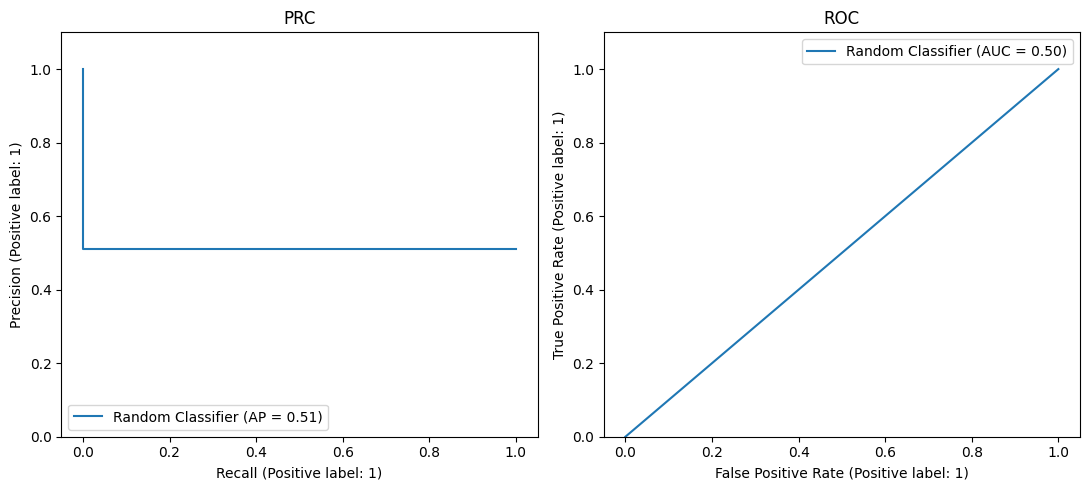

In [5]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
    if ax is None:
      fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    print(classifier_name, 'metrics')
    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    print('AUC-PR: %.5f' % auc(recall, precision))
    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)

    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
    print('AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [6]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])
precision, recall, _ = precision_recall_curve(y_test, y_random)
  # добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_random),
      0
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.755833,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`).

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [7]:
from sklearn.svm import SVC


x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=rnd_state)
AUCs = []

for C in np.logspace(-5, 1, 20):
    model = SVC(kernel='linear', C=C, random_state=rnd_state).fit(x_train, y_train)
    preds = model.decision_function(x_val)
    precision, recall, thresholds = precision_recall_curve(y_val, preds)
    AUCs.append(auc(recall, precision))

best_C = np.logspace(-5, 1, 20)[np.argmax(AUCs)]
print(f'Best C const: {best_C:.5f}')

Best C const: 0.00038


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

SVM metrics
AUC-PR: 0.86166
AUC-ROC: 0.86811


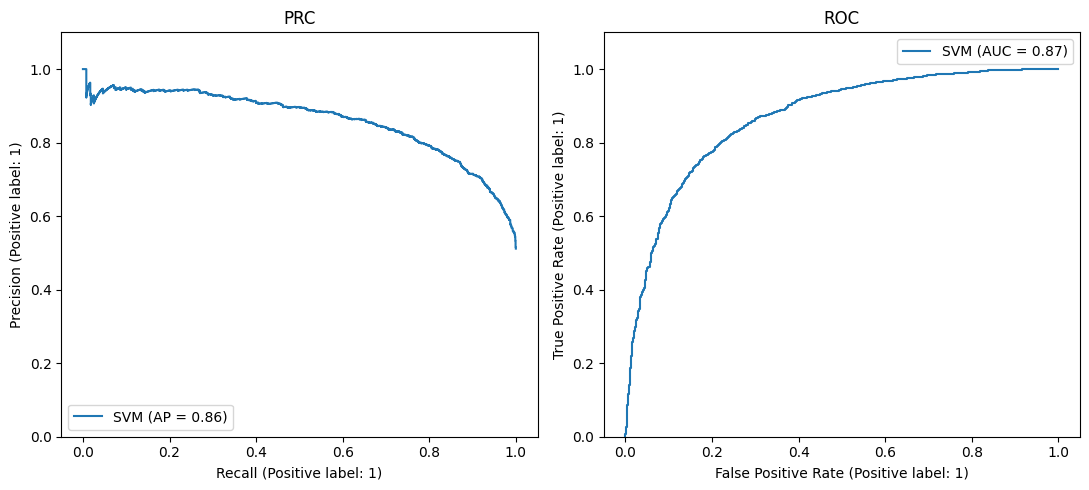

In [8]:
model = SVC(kernel='linear', C=best_C, random_state=rnd_state).fit(x_train, y_train)
preds = model.decision_function(x_test)
precision, recall, thresholds = precision_recall_curve(y_test, preds)

depict_pr_roc(y_test, preds, 'SVM')

In [9]:
df_metrics.loc['SVM'] = [
      auc(recall, precision),
      roc_auc_score(y_test, preds),
      best_C
]

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [10]:
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.755833,0.500000,0.000000
SVM,0.861663,0.868107,0.000379


__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [11]:
from sklearn.linear_model import LogisticRegression


AUCs = []

for C in np.logspace(-5, 1, 20):
    model = LogisticRegression(penalty='l2', C=C, random_state=rnd_state).fit(x_train, y_train)
    probs = model.predict_proba(x_val)[:, 1]
    precision, recall, threshold = precision_recall_curve(y_val, probs)
    AUCs.append(auc(recall, precision))

best_C = np.logspace(-5, 1, 20)[np.argmax(AUCs)]

print(f'Best C const: {best_C:.5f}')

Best C const: 0.00162


Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

Logistic Regression metrics
AUC-PR: 0.86309
AUC-ROC: 0.87133


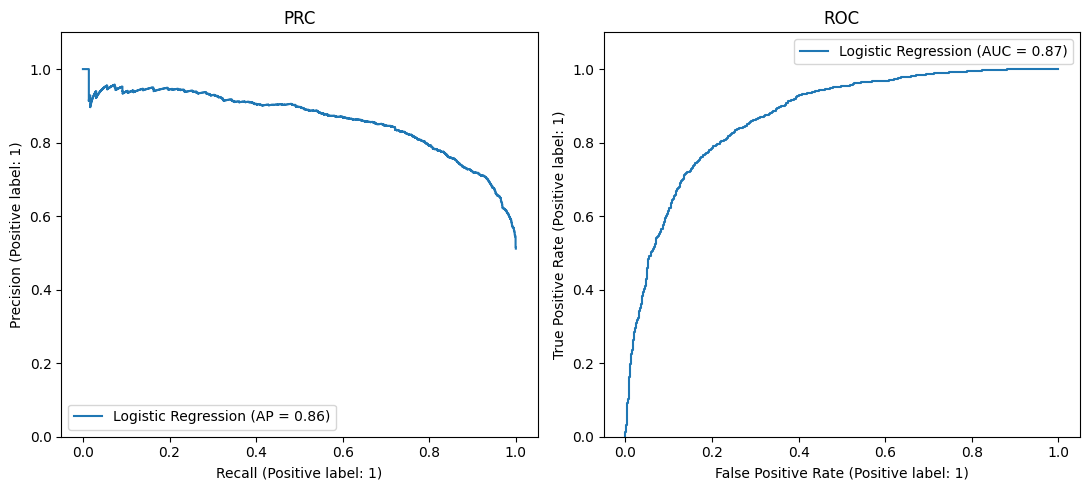

In [12]:
model = LogisticRegression(penalty='l2', C=best_C, random_state=rnd_state).fit(x_train, y_train)
probs = model.predict_proba(x_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, probs)

depict_pr_roc(y_test, probs, 'Logistic Regression')

In [13]:
df_metrics.loc['Logistic Regression'] = [
      auc(recall, precision),
      roc_auc_score(y_test, probs),
      best_C
]

In [14]:
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.755833,0.500000,0.000000
SVM,0.861663,0.868107,0.000379
Logistic Regression,0.863094,0.871335,0.001624


**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ: В целом оба метода крайне похожи и отличаются друг от друга только в пределах погрешности.**

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`).

In [15]:
import seaborn as sns


X, y = make_classification(n_samples=2000, n_features=2, n_informative=2, n_redundant=0, random_state=rnd_state)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rnd_state)

model = SVC(kernel='linear', random_state=rnd_state).fit(x_train, y_train)

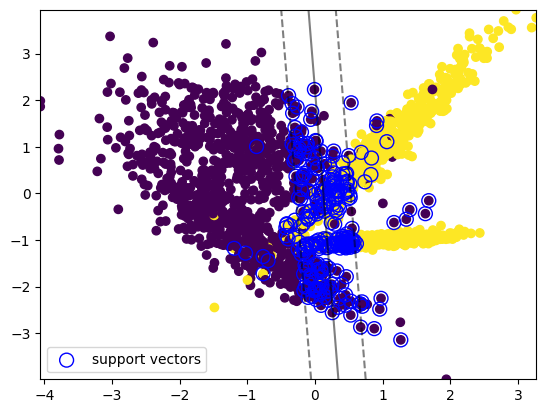

In [16]:
def plot_svm_2D(X, y, model, plot_support=True):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(30, 30)

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])


    #Отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1], c=y)

    #Отрисовали опорные векторы
    if plot_support:
        plt.scatter(model.support_vectors_[:, 0],
                    model.support_vectors_[:, 1],
                    label='support vectors',
                    s=100,
                    linewidth=1,
                    edgecolor="blue",
                    facecolors='none')

    plt.legend()

plot_svm_2D(X, y, model)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ: Это объекты, которые влияют на положение и угол поворота гиперплоскости (ее построение).**

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [17]:
model = LogisticRegression(penalty='l2', random_state=rnd_state).fit(x_train, y_train)

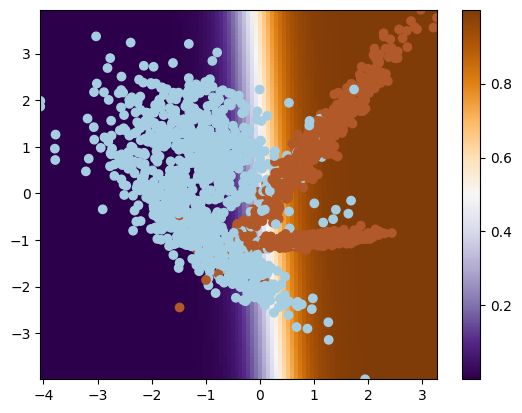

In [18]:
def plot_logreg_2D(X, y, model):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)[:, 1]
    Z = Z.reshape((xx.shape[0], -1)).T


    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)

    #Отрисовали выборку
    plt.scatter(X[:, 0],
                X[:, 1],
                c=y,
                cmap=plt.cm.Paired)

    plt.colorbar(image)


plot_logreg_2D(X, y, model)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ: Чем ближе мы к гиперплоскости, тем ближе отступ к нулю, а это значит что объект ближе к границе классов и модель не может определить его с высокой вероятностью (отсюда и получается 0.5).**

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [19]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2) # '-' --> '+'
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1)) # min() --> mean()
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [20]:
X, y = make_classification(n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=rnd_state)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rnd_state)

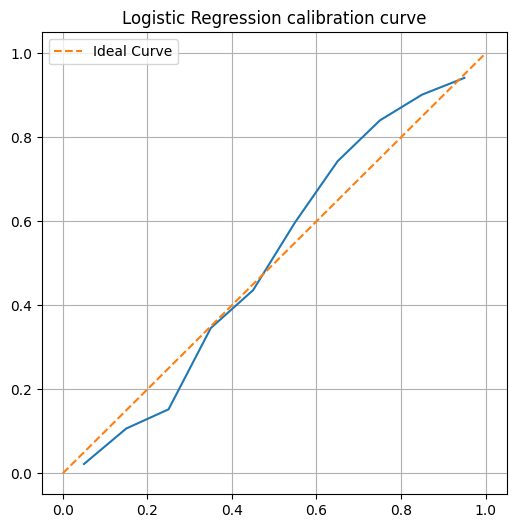

In [21]:
model = LogisticRegression(penalty='l2', C=df_metrics.loc['Logistic Regression', 'reg_const'], random_state=rnd_state).fit(x_train, y_train)
probs = model.predict_proba(x_test)[:, 1]
plot_calibration_curve(y_test, probs)

plt.title('Logistic Regression calibration curve');
plt.plot([0, 1], [0, 1], '--', label='Ideal Curve')
plt.legend()
plt.show()

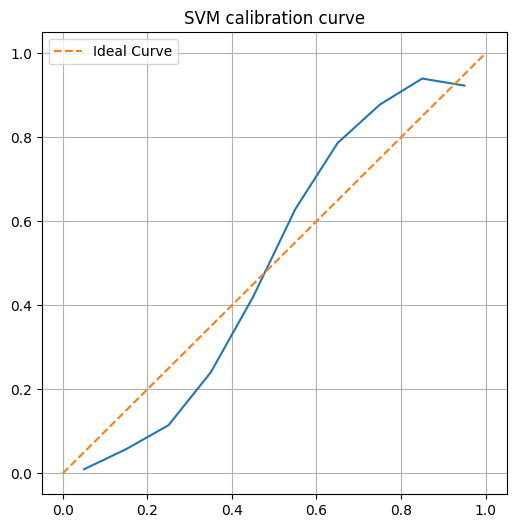

In [22]:
from scipy.special import expit


model = SVC(kernel='linear', C=df_metrics.loc['SVM', 'reg_const'], random_state=rnd_state).fit(x_train, y_train)
preds = expit(model.decision_function(x_test))
plot_calibration_curve(y_test, preds)

plt.title('SVM calibration curve');
plt.plot([0, 1], [0, 1], '--', label='Ideal Curve')
plt.legend()
plt.show()

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии?

**Ответ: Логистическая регрессия очень близка к идеальной диагонали, SVM выглядит похуже.**

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

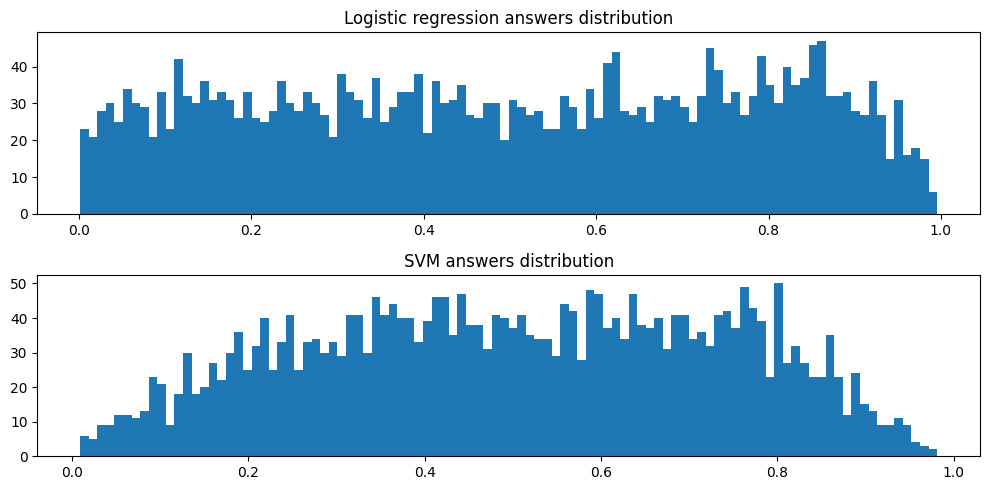

In [23]:
fig, ax = plt.subplots(2, figsize=(10, 5))
ax[0].hist(probs, bins=100);
ax[1].hist(preds, bins=100);

ax[0].set(title="Logistic regression answers distribution");
ax[1].set(title="SVM answers distribution");

plt.tight_layout()
plt.show()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ: Логистическая регрессия выглядит почти как равномерное распределение (потому что более корректно оценивает вероятности), а SVM похож на нормальное распределение (так как используем support vectors).**

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

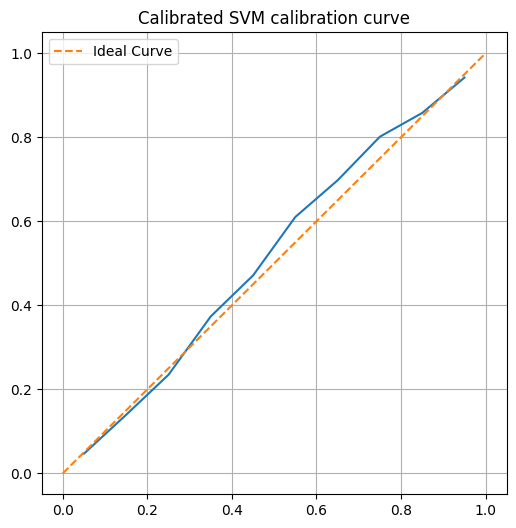

In [24]:
from sklearn.calibration import CalibratedClassifierCV


calib_model = CalibratedClassifierCV(model, cv='prefit').fit(x_train, y_train)
calib_probs = calib_model.predict_proba(x_test)[:,1]
plot_calibration_curve(y_test, calib_probs)

plt.title('Calibrated SVM calibration curve');
plt.plot([0, 1], [0, 1], '--', label='Ideal Curve')
plt.legend()
plt.show()

**Вопрос:** Улучшилась ли калибровочная кривая?

**Ответ: Да, значительно, теперь почти полностью совпадает с идеальным вариантом.**

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [25]:
#your code here

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [26]:
df = pd.read_csv('bike_buyers.csv')

numerical = ['Income', 'Age', 'Children', 'Cars']
categorical = ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region']

#Заменим пропуски категориальных переменных
df[categorical] = df[categorical].fillna('undefined')

X = df.drop(columns=['Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')

#Разделим на категориальные признаки и числовые

X_numerical = X[numerical]
X_categorical = X[categorical]

В начале поработаем только с категориальными признаками

In [27]:
x_train, x_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [28]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


def get_pipeline(encoder, categorical):
    column_transformer = ColumnTransformer([
        ('encoder', encoder, categorical)
    ])

    pipeline = Pipeline([
        ('transformer', column_transformer),
        ('logreg', LogisticRegression(penalty='l2', random_state=rnd_state, max_iter=300))
    ])
    return pipeline

def calc_AUC(model, x_test, y_test, i=True):
    probs = model.predict_proba(x_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, probs)
    if i:
        print(f'AUC-PR: {auc(recall, precision):.5f}')
    return auc(recall, precision)

In [29]:
pipeline = get_pipeline(OrdinalEncoder(), categorical)

In [30]:
%%time
model = pipeline.fit(x_train, y_train)

CPU times: user 21.6 ms, sys: 0 ns, total: 21.6 ms
Wall time: 22.2 ms


In [31]:
_ = calc_AUC(model, x_test, y_test)

AUC-PR: 0.57894


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [32]:
pipeline = get_pipeline(OneHotEncoder(), categorical)

In [33]:
%%time
model = pipeline.fit(x_train, y_train)

CPU times: user 36.1 ms, sys: 0 ns, total: 36.1 ms
Wall time: 49.5 ms


In [34]:
_ = calc_AUC(model, x_test, y_test)

AUC-PR: 0.66186


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [35]:
from sklearn.base import BaseEstimator, TransformerMixin


class MeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.encoded = {}
        for column in self.columns:
            self.encoded[column] = {}

    def fit(self, X, y):
        for column in self.columns:
            for x_j in X[column].unique():
                mask = (X[column] == x_j)
                self.encoded[column][x_j] = (mask & (y == 1)).sum() / mask.sum()
        return self

    def transform(self, X):
        X = X.copy(deep=True)
        for column in self.columns:
            values = []
            for index, row in X.iterrows():
                values.append(self.encoded[column][row[column]])
            X[column] = values
        return X

In [36]:
pipeline = get_pipeline(MeanTargetEncoder(categorical), categorical)

In [37]:
%%time
model = pipeline.fit(x_train, y_train)

CPU times: user 260 ms, sys: 1.11 ms, total: 261 ms
Wall time: 262 ms


In [38]:
_ = calc_AUC(model, x_test, y_test)

AUC-PR: 0.65269


**Время значительно выросло, чего нельзя сказать о метрике (OneHotEncoder получше будет).**

##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [39]:
class SuperDuperMeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.encoded = None

    def fit(self, X, y):
        df = pd.concat((X, pd.DataFrame(y)), axis=1)
        self.encoded = {column: df.groupby(column)['Purchased Bike'].mean() for column in self.columns}
        return self

    def transform(self, X):
        X = X.copy(deep=True)
        for column in self.columns:
            X[column] = X[column].map(self.encoded[column])
        return X

In [40]:
pipeline = get_pipeline(SuperDuperMeanTargetEncoder(categorical), categorical)

In [41]:
%%time
model = pipeline.fit(x_train, y_train)

CPU times: user 21.9 ms, sys: 953 µs, total: 22.9 ms
Wall time: 28.9 ms


In [42]:
_ = calc_AUC(model, x_test, y_test)

AUC-PR: 0.65269


**После оптимизации наш энкодер работает примерно так же, как и OneHot по времени и метрике.**

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [43]:
import random


class MeanTargetEncoderWithNoise(SuperDuperMeanTargetEncoder):
    def __init__(self, columns):
        super().__init__(columns)
        self.rnd = random.Random(3)

    def fit(self, X, y):
        df = pd.concat((X, pd.DataFrame(y)), axis=1)
        self.encoded = {column: df.groupby(column)['Purchased Bike'].mean() +
                        self.rnd.randint(-1, 1) / 10 for column in self.columns}
        return self

In [44]:
pipeline = get_pipeline(MeanTargetEncoderWithNoise(categorical), categorical)

In [45]:
%%time
model = pipeline.fit(x_train, y_train)

CPU times: user 30.2 ms, sys: 2.06 ms, total: 32.3 ms
Wall time: 35.6 ms


In [46]:
_ = calc_AUC(model, x_test, y_test)

AUC-PR: 0.65272


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ: Нет, добавление шума почти никак не изменило картину, потому что малые изменения в итоговых значениях в целом не меняют модель.**

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [47]:
from math import floor


class CrossFoldedMeanTargetEncoder(SuperDuperMeanTargetEncoder):
    def __init__(self, columns):
        super().__init__(columns)
        self.folds = 5

    def fit(self, X, y):
        df = pd.concat((X, pd.DataFrame(y)), axis=1)
        chunks = np.array_split(df, self.folds)
        AUCs = []
        iter = 0
        for chunk in chunks:
            x_train = df.drop(chunk.index)
            y_train = x_train['Purchased Bike']
            x_train.drop(columns='Purchased Bike', inplace=True)
            x_test = chunk
            y_test = x_test['Purchased Bike']
            x_test.drop(columns='Purchased Bike', inplace=True)

            column_transformer = ColumnTransformer([
                ('crossmte', MeanTargetEncoderWithNoise(self.columns), self.columns),
            ])

            pipeline = Pipeline([
                ('transformer', column_transformer),
                ('logreg', LogisticRegression(penalty='l2', random_state=rnd_state))
            ])

            model = pipeline.fit(x_train, y_train)
            probs = model.predict_proba(x_test)[:, 1]
            precision, recall, thresholds = precision_recall_curve(y_test, probs)
            AUC = auc(recall, precision)
            print(f'AUC-PR: {AUC:.5f} on iter: {iter}')
            AUCs.append(AUC)
            iter += 1

        best_chunk = chunks[np.argmax(AUCs)]
        x_train = df.drop(best_chunk.index)
        y_train = x_train['Purchased Bike']
        x_train.drop(columns='Purchased Bike', inplace=True)

        enc = MeanTargetEncoderWithNoise(self.columns)
        self.encoded = enc.fit(x_train, y_train).encoded
        return self

In [48]:
pipeline = get_pipeline(CrossFoldedMeanTargetEncoder(categorical), categorical)

In [49]:
%%time
model = pipeline.fit(x_train, y_train)

AUC-PR: 0.60038 on iter: 0
AUC-PR: 0.47691 on iter: 1
AUC-PR: 0.57211 on iter: 2
AUC-PR: 0.63819 on iter: 3
AUC-PR: 0.67625 on iter: 4
CPU times: user 189 ms, sys: 3 ms, total: 192 ms
Wall time: 207 ms


In [50]:
_ = calc_AUC(model, x_test, y_test)

AUC-PR: 0.68104


**Кажется что мы получили неплохой буст по сравнению с остальными энкодерами.**

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [51]:
class SmoothMeanTargetEncoder(SuperDuperMeanTargetEncoder):
    def __init__(self, columns, C):
        super().__init__(columns)
        self.global_mean = None
        self.C = C

    def fit(self, X, y):
        self.global_mean = y.mean()
        df = pd.concat((X, pd.DataFrame(y)), axis=1)
        self.encoded = {column: (df.groupby(column)['Purchased Bike'].sum() + self.C * self.global_mean) /
                         (df.groupby(column)['Purchased Bike'].count() + self.C) for column in self.columns}
        return self

In [52]:
pipeline = get_pipeline(SmoothMeanTargetEncoder(categorical, 10), categorical)

In [53]:
%%time
model = pipeline.fit(x_train, y_train)

CPU times: user 49 ms, sys: 7.07 ms, total: 56 ms
Wall time: 51.3 ms


In [54]:
_ = calc_AUC(model, x_test, y_test)

AUC-PR: 0.66974


**Даже подбирать ничего не пришлось, с предложенным $C = 10$ качество получается уже лучше.**

#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к признакам-счетчикам.


В данных есть пропуски - замените их средним значением признака



In [55]:
df[numerical] = df[numerical].fillna(df[numerical].mean())

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?

In [56]:
def run_with_new_categorical(new_features):
    final = categorical + new_features
    x_train, x_test, y_train, y_test = train_test_split(df[final], y, test_size=0.25, random_state=777, stratify=y)
    pipeline = get_pipeline(SmoothMeanTargetEncoder(final, 10), final)
    model = pipeline.fit(x_train, y_train)
    print('With:', new_features)
    _ = calc_AUC(model, x_test, y_test)

In [57]:
run_with_new_categorical(['Income'])
run_with_new_categorical(['Age'])
run_with_new_categorical(['Children'])
run_with_new_categorical(['Cars'])
run_with_new_categorical(['Income', 'Age', 'Children', 'Cars'])

With: ['Income']
AUC-PR: 0.71586
With: ['Age']
AUC-PR: 0.62435
With: ['Children']
AUC-PR: 0.65660
With: ['Cars']
AUC-PR: 0.69367
With: ['Income', 'Age', 'Children', 'Cars']
AUC-PR: 0.66542


**Ответ: Да, определенно некоторые признаки заметно улучшают модель.**

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

**Ответ: OneHotEncoder увеличивает количество признаков, что усложняет расчеты и не всегда приемлемо для больших моделей. Но зато он менее подвержен перобучению и не надо придумывать как с ним бороться.**

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [58]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2023-11-22 19:07:05--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.data’

adult.data              [   <=>              ]   3.79M  7.50MB/s    in 0.5s    

2023-11-22 19:07:06 (7.50 MB/s) - ‘adult.data’ saved [3974305]



In [59]:
columns = ['age', 'workclass', 'fnlwgt', 'education',
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
7779,17,Private,287160,11th,7,Never-married,Other-service,Own-child,White,Female,0,0,15,United-States,0


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`.

In [60]:
from sklearn.feature_selection import SelectFromModel


X = df.drop(columns='income')
y = df['income']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [61]:
categorical = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
numerical = list(set(columns) - set(categorical) - {'income'})

print("Before:", len(categorical))
new_x = pd.get_dummies(X[categorical], columns=categorical)
print("After:", new_x.shape[1])

Before: 8
After: 102


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [62]:
column_transformer = ColumnTransformer([
    ('encoder', OneHotEncoder(), categorical),
    ('other', 'passthrough', numerical)
])

pipeline = Pipeline([
    ('transformer', column_transformer),
    ('logreg', LogisticRegression(penalty='l2', random_state=rnd_state, max_iter=300))
])

model = pipeline.fit(x_train, y_train)
_ = calc_AUC(model, x_test, y_test)

AUC-PR: 0.45033


#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [63]:
def features_sorter(transformer, pipeline, x_train, y_train, x_test, y_test, n_fit=False):
    if n_fit:
        pipeline.fit(transformer.transform(x_train), y_train)
    else:
        pipeline.fit(x_train, y_train)
    threshold = np.sort(np.abs(pipeline.named_steps['logreg'].coef_))[0][-40]

    selector = SelectFromModel(pipeline.named_steps['logreg'], threshold=threshold)
    selected_features = selector.get_feature_names_out(input_features=transformer.get_feature_names_out())
    print(f"Selected features: {[f for f in selected_features]}")

    new_x_train = selector.fit_transform(transformer.transform(x_train), y_train)
    new_x_test = selector.transform(transformer.transform(x_test))

    model = LogisticRegression(penalty='l2', random_state=rnd_state, max_iter=300)
    model = model.fit(new_x_train, y_train)
    _ = calc_AUC(model, new_x_test, y_test)

In [64]:
%%time

column_transformer = ColumnTransformer([
    ('encoder', OneHotEncoder(), categorical),
    ('other', 'passthrough', numerical)
])

pipeline = Pipeline([
    ('transformer', column_transformer),
    ('logreg', LogisticRegression(penalty='l2', random_state=rnd_state, max_iter=300))
])

features_sorter(column_transformer, pipeline, x_train, y_train, x_test, y_test)

Selected features: ['encoder__workclass_ ?', 'encoder__workclass_ Private', 'encoder__workclass_ Self-emp-inc', 'encoder__education_ 10th', 'encoder__education_ 11th', 'encoder__education_ Bachelors', 'encoder__education_ Doctorate', 'encoder__education_ HS-grad', 'encoder__education_ Masters', 'encoder__education_ Prof-school', 'encoder__education_ Some-college', 'encoder__marital-status_ Divorced', 'encoder__marital-status_ Married-civ-spouse', 'encoder__marital-status_ Never-married', 'encoder__marital-status_ Separated', 'encoder__marital-status_ Widowed', 'encoder__occupation_ ?', 'encoder__occupation_ Adm-clerical', 'encoder__occupation_ Craft-repair', 'encoder__occupation_ Exec-managerial', 'encoder__occupation_ Farming-fishing', 'encoder__occupation_ Handlers-cleaners', 'encoder__occupation_ Machine-op-inspct', 'encoder__occupation_ Other-service', 'encoder__occupation_ Prof-specialty', 'encoder__relationship_ Husband', 'encoder__relationship_ Not-in-family', 'encoder__relation

Изменилось ли качество? Как?

**Ответ: Стало значительно лучше. Видимо без избыточного количества признаков модели становится полегче.**

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [65]:
from sklearn.preprocessing import StandardScaler


column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('standardscaler', StandardScaler(), numerical)
])

pipeline = Pipeline([
    ('transformer', column_transformer),
    ('logreg', LogisticRegression(max_iter=300))
])

model = pipeline.fit(x_train, y_train)
_ = calc_AUC(model, x_test, y_test)

AUC-PR: 0.76713


In [66]:
%%time

column_transformer = ColumnTransformer([
    ('encoder', OneHotEncoder(), categorical),
    ('standardscaler', StandardScaler(), numerical)
])

pipeline = Pipeline([
    ('transformer', column_transformer),
    ('logreg', LogisticRegression(penalty='l2', random_state=rnd_state, max_iter=300))
])

features_sorter(column_transformer, pipeline, x_train, y_train, x_test, y_test)

Selected features: ['encoder__workclass_ Federal-gov', 'encoder__workclass_ Without-pay', 'encoder__education_ 1st-4th', 'encoder__education_ 5th-6th', 'encoder__education_ Preschool', 'encoder__marital-status_ Divorced', 'encoder__marital-status_ Married-AF-spouse', 'encoder__marital-status_ Married-civ-spouse', 'encoder__marital-status_ Married-spouse-absent', 'encoder__marital-status_ Never-married', 'encoder__marital-status_ Separated', 'encoder__occupation_ Exec-managerial', 'encoder__occupation_ Farming-fishing', 'encoder__occupation_ Other-service', 'encoder__occupation_ Priv-house-serv', 'encoder__occupation_ Prof-specialty', 'encoder__occupation_ Protective-serv', 'encoder__occupation_ Tech-support', 'encoder__relationship_ Other-relative', 'encoder__relationship_ Own-child', 'encoder__relationship_ Wife', 'encoder__sex_ Female', 'encoder__native-country_ Cambodia', 'encoder__native-country_ Canada', 'encoder__native-country_ Columbia', 'encoder__native-country_ Cuba', 'encode

**Ответ: Скейлинг признаков дал хороший буст в самом начале, а отбор лишних даже немного снизил качество.**

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [67]:
%%time

x_train_new = column_transformer.transform(x_train)
x_test_new = column_transformer.transform(x_test)
scaler = StandardScaler(with_mean=False).fit(x_train_new, y_train)

pipeline = Pipeline([
    ('logreg', LogisticRegression(penalty='l2', random_state=rnd_state, max_iter=300))
])

features_sorter(scaler, pipeline, x_train_new, y_train, x_test_new, y_test, True)

Selected features: ['x1', 'x6', 'x8', 'x9', 'x10', 'x14', 'x18', 'x19', 'x21', 'x22', 'x23', 'x25', 'x27', 'x28', 'x29', 'x30', 'x31', 'x36', 'x37', 'x38', 'x40', 'x41', 'x42', 'x43', 'x45', 'x47', 'x48', 'x49', 'x50', 'x51', 'x52', 'x58', 'x59', 'x64', 'x88', 'x102', 'x104', 'x105', 'x106', 'x107']
AUC-PR: 0.76109
CPU times: user 1.84 s, sys: 13.4 ms, total: 1.85 s
Wall time: 1.86 s


**Ответ: Список получили другой, а качество выросло только до уровня простого скейлинга числовых признаков.**

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



In [68]:
def statistic(X, y):
    positive = X[y == 1]
    negative = X[~(y == 1)]
    res = np.abs(positive.mean(axis=0) - negative.mean(axis=0))
    pos_var = positive.shape[0] * np.var(positive, axis=0)
    neg_var = negative.shape[0] * np.var(negative, axis=0)
    res /= np.sqrt((pos_var + neg_var) / y.shape[0])
    return res

In [69]:
%%time

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('standardscaler', StandardScaler(), numerical)
])

x_train_new = column_transformer.fit_transform(x_train, y_train)
x_test_new = column_transformer.transform(x_test)

t_stats = np.asarray(statistic(x_train_new.todense(order='C'), y_train)).flatten()
mask = (t_stats >= np.sort(t_stats)[-40])
features = column_transformer.get_feature_names_out()[mask]
print(f'Selected features: {[f for f in features]}')

model = LogisticRegression(penalty='l2', random_state=rnd_state, max_iter=300)
model = model.fit(x_train_new[:, mask], y_train)
_ = calc_AUC(model, x_test_new[:, mask], y_test)

Selected features: ['ohe__workclass_ ?', 'ohe__workclass_ Federal-gov', 'ohe__workclass_ Private', 'ohe__workclass_ Self-emp-inc', 'ohe__education_ 10th', 'ohe__education_ 11th', 'ohe__education_ Bachelors', 'ohe__education_ Doctorate', 'ohe__education_ HS-grad', 'ohe__education_ Masters', 'ohe__education_ Prof-school', 'ohe__education_ Some-college', 'ohe__marital-status_ Divorced', 'ohe__marital-status_ Married-civ-spouse', 'ohe__marital-status_ Never-married', 'ohe__marital-status_ Separated', 'ohe__marital-status_ Widowed', 'ohe__occupation_ ?', 'ohe__occupation_ Adm-clerical', 'ohe__occupation_ Exec-managerial', 'ohe__occupation_ Handlers-cleaners', 'ohe__occupation_ Machine-op-inspct', 'ohe__occupation_ Other-service', 'ohe__occupation_ Prof-specialty', 'ohe__relationship_ Husband', 'ohe__relationship_ Not-in-family', 'ohe__relationship_ Other-relative', 'ohe__relationship_ Own-child', 'ohe__relationship_ Unmarried', 'ohe__relationship_ Wife', 'ohe__race_ Black', 'ohe__race_ Whit

#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [70]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('standardscaler', StandardScaler(), numerical)
])

x_train_new = column_transformer.fit_transform(x_train, y_train)
x_test_new = column_transformer.transform(x_test)

features = column_transformer.get_feature_names_out()
mask = [True for f in features]
x_train_stripped, x_val_stripped, y_train_new, y_val = train_test_split(x_train_new, y_train, test_size=0.2, random_state=777, stratify=y_train)

# while np.sum(mask) > 40:
#     print(f'iter: {np.sum(mask)}')

#     best_AUC = 0
#     least_pos = None
#     for i in range(len(mask)):
#         if not mask[i]:
#             continue
#         mask[i] = False

#         model = LogisticRegression(penalty='l2', random_state=rnd_state, max_iter=300).fit(x_train_stripped[:, mask], y_train_new)
#         AUC = calc_AUC(model, x_val_stripped[:, mask], y_val, False)

#         if AUC > best_AUC:
#             best_AUC = AUC
#             least_pos = i
#         mask[i] = True

#     print(f'Best AUC: {best_AUC:.5f}')
#     mask[least_pos] = False

In [71]:
# iter: 108
# Best AUC: 0.77366
# iter: 107
# Best AUC: 0.77384
# iter: 106
# Best AUC: 0.77400
# iter: 105
# Best AUC: 0.77424
# iter: 104
# Best AUC: 0.77443
# iter: 103
# Best AUC: 0.77455
# iter: 102
# Best AUC: 0.77465
# iter: 101
# Best AUC: 0.77516
# iter: 100
# Best AUC: 0.77541
# iter: 99
# Best AUC: 0.77554
# iter: 98
# Best AUC: 0.77560
# iter: 97
# Best AUC: 0.77567
# iter: 96
# Best AUC: 0.77574
# iter: 95
# Best AUC: 0.77576
# iter: 94
# Best AUC: 0.77581
# iter: 93
# Best AUC: 0.77585
# iter: 92
# Best AUC: 0.77589
# iter: 91
# Best AUC: 0.77614
# iter: 90
# Best AUC: 0.77616
# iter: 89
# Best AUC: 0.77618
# iter: 88
# Best AUC: 0.77619
# iter: 87
# Best AUC: 0.77619
# iter: 86
# Best AUC: 0.77619
# iter: 85
# Best AUC: 0.77620
# iter: 84
# Best AUC: 0.77621
# iter: 83
# Best AUC: 0.77620
# iter: 82
# Best AUC: 0.77620
# iter: 81
# Best AUC: 0.77621
# iter: 80
# Best AUC: 0.77622
# iter: 79
# Best AUC: 0.77622
# iter: 78
# Best AUC: 0.77622
# iter: 77
# Best AUC: 0.77622
# iter: 76
# Best AUC: 0.77622
# iter: 75
# Best AUC: 0.77622
# iter: 74
# Best AUC: 0.77622
# iter: 73
# Best AUC: 0.77621
# iter: 72
# Best AUC: 0.77622
# iter: 71
# Best AUC: 0.77621
# iter: 70
# Best AUC: 0.77621
# iter: 69
# Best AUC: 0.77621
# iter: 68
# Best AUC: 0.77620
# iter: 67
# Best AUC: 0.77620
# iter: 66
# Best AUC: 0.77620
# iter: 65
# Best AUC: 0.77620
# iter: 64
# Best AUC: 0.77619
# iter: 63
# Best AUC: 0.77618
# iter: 62
# Best AUC: 0.77620
# iter: 61
# Best AUC: 0.77621
# iter: 60
# Best AUC: 0.77621
# iter: 59
# Best AUC: 0.77630
# iter: 58
# Best AUC: 0.77635
# iter: 57
# Best AUC: 0.77633
# iter: 56
# Best AUC: 0.77635
# iter: 55
# Best AUC: 0.77633
# iter: 54
# Best AUC: 0.77632
# iter: 53
# Best AUC: 0.77634
# iter: 52
# Best AUC: 0.77633
# iter: 51
# Best AUC: 0.77628
# iter: 50
# Best AUC: 0.77624
# iter: 49
# Best AUC: 0.77621
# iter: 48
# Best AUC: 0.77616
# iter: 47
# Best AUC: 0.77610
# iter: 46
# Best AUC: 0.77603
# iter: 45
# Best AUC: 0.77600
# iter: 44
# Best AUC: 0.77595
# iter: 43
# Best AUC: 0.77582
# iter: 42
# Best AUC: 0.77571
# iter: 41
# Best AUC: 0.77561

In [72]:
# model = LogisticRegression(penalty='l2', random_state=rnd_state, max_iter=300)
# model = model.fit(x_train_new, y_train)
# _ = calc_AUC(model, x_test_new, y_test)

In [73]:
# AUC-PR: 0.76712

**Ответ: Отбор занял неприлично много времени, около 40 минут (я закомменчу код и вывод, чтобы было представление что получилось без пересчета).**

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [74]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('standardscaler', StandardScaler(), numerical)
])

x_train_new = column_transformer.fit_transform(x_train, y_train)
x_test_new = column_transformer.transform(x_test)

features = column_transformer.get_feature_names_out()
mask = [False for f in features]
x_train_added, x_val_added, y_train_new, y_val = train_test_split(x_train_new, y_train, test_size=0.2, random_state=777, stratify=y_train)

while np.sum(mask) < 40:
    print(f'iter: {np.sum(mask)}')

    best_AUC = 0
    best_pos = None
    for i in range(len(mask)):
        if mask[i]:
            continue
        mask[i] = True
        model = LogisticRegression(penalty='l2', random_state=rnd_state, max_iter=300).fit(x_train_added[:, mask], y_train_new)

        AUC = calc_AUC(model, x_val_added[:, mask], y_val, False)
        if AUC > best_AUC:
            best_AUC = AUC
            best_pos = i
        mask[i] = False

    print(f'Best AUC: {best_AUC:.5f}')
    mask[best_pos] = True

iter: 0
Best AUC: 0.67536
iter: 1
Best AUC: 0.67890
iter: 2
Best AUC: 0.68316
iter: 3
Best AUC: 0.73493
iter: 4
Best AUC: 0.74434
iter: 5
Best AUC: 0.75069
iter: 6
Best AUC: 0.75436
iter: 7
Best AUC: 0.75720
iter: 8
Best AUC: 0.75978
iter: 9
Best AUC: 0.76205
iter: 10
Best AUC: 0.76331
iter: 11
Best AUC: 0.76445
iter: 12
Best AUC: 0.76654
iter: 13
Best AUC: 0.76778
iter: 14
Best AUC: 0.76880
iter: 15
Best AUC: 0.77005
iter: 16
Best AUC: 0.77088
iter: 17
Best AUC: 0.77141
iter: 18
Best AUC: 0.77182
iter: 19
Best AUC: 0.77226
iter: 20
Best AUC: 0.77276
iter: 21
Best AUC: 0.77313
iter: 22
Best AUC: 0.77349
iter: 23
Best AUC: 0.77372
iter: 24
Best AUC: 0.77391
iter: 25
Best AUC: 0.77411
iter: 26
Best AUC: 0.77428
iter: 27
Best AUC: 0.77449
iter: 28
Best AUC: 0.77467
iter: 29
Best AUC: 0.77483
iter: 30
Best AUC: 0.77499
iter: 31
Best AUC: 0.77516
iter: 32
Best AUC: 0.77527
iter: 33
Best AUC: 0.77544
iter: 34
Best AUC: 0.77562
iter: 35
Best AUC: 0.77571
iter: 36
Best AUC: 0.77578
iter: 37
Be

**Ответ: Судя по получающимся метрикам с какого то момента добавление признаков мало улучшает модель, но колебаний в качестве не происходит. Возможно, на большем наборе признаков это проявится.**

In [75]:
model = LogisticRegression(penalty='l2', random_state=rnd_state, max_iter=300)
model = model.fit(x_train_new[:, mask], y_train)
_ = calc_AUC(model, x_test_new[:, mask], y_test)

AUC-PR: 0.76477


Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ: Встроенные методы дают хорошие результаты при не самой быстрой работе. Метод фильтрации дает схожий результат на их уровне, но за гораздо более быстрое время. Жадные алгоритмы с итерационным отбором признаков работают очень долго и представляют интерес только при больших мощностях железа на котором все считается (40 и 10 минут это многовато).**

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [76]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2023-11-22 19:15:53--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank-additional.zip’

bank-additional.zip     [  <=>               ] 434.15K  1.38MB/s    in 0.3s    

2023-11-22 19:15:53 (1.38 MB/s) - ‘bank-additional.zip’ saved [444572]

Archive:  bank-additional.zip
   creating: bank-additional/
  inflating: bank-additional/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/bank-additional/
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/._bank-additional  


In [77]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [78]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [79]:
from sklearn.model_selection import KFold

columns = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
categorical = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
numerical = list(set(columns) - set(categorical))

cv_folder = KFold(n_splits=5, shuffle=True, random_state=500)

Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [80]:
column_transformer = ColumnTransformer([
    ('categorical', OneHotEncoder(), categorical),
    ('numeric', StandardScaler(), numerical)
])

x_transformed = column_transformer.fit_transform(X)
preds = np.zeros(y.shape[0])
model = LogisticRegression(penalty='l2', random_state=rnd_state, max_iter=300)

for train_ind, test_ind in cv_folder.split(x_transformed):
    model.fit(x_transformed[train_ind], y[train_ind])
    preds[test_ind] = model.predict(x_transformed[test_ind])

Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [81]:
income = []
salaries = []
for train_ind, test_ind in cv_folder.split(x_transformed):
    income.append(np.sum(y[test_ind][preds[test_ind] == 1]) * 10)
    salaries.append(np.sum(preds[test_ind]))

print(f'Mean income: {np.mean(income):.2f}')
print(f'Income deviation: {np.std(income):.2f}')
print(f'Salaries: {np.mean(salaries):.2f}')
print(f'Salaries deviation: {np.std(salaries):.2f}')

Mean income: 2132.00
Income deviation: 104.00
Salaries: 324.40
Salaries deviation: 7.84


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [82]:
for i in range(5):
    income = []
    salaries = []

    for train_ind, test_ind in cv_folder.split(x_transformed):
        coeffs = np.random.uniform(0, 20, y[test_ind][preds[test_ind] == 1].shape[0])
        income.append(np.sum(y[test_ind][preds[test_ind] == 1] * coeffs))

    print(f'Mean income: {np.mean(income):.2f}')
    print(f'Income deviation: {np.std(income):.2f}\n')

Mean income: 2137.38
Income deviation: 51.46

Mean income: 2070.94
Income deviation: 106.93

Mean income: 2154.09
Income deviation: 141.39

Mean income: 2137.53
Income deviation: 83.76

Mean income: 2048.93
Income deviation: 119.98



**Ответ: В целом мы получаем примерно те же значения, что и при фиксированной сумме. Зарплаты при этом константны, по понятным причинам.**

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

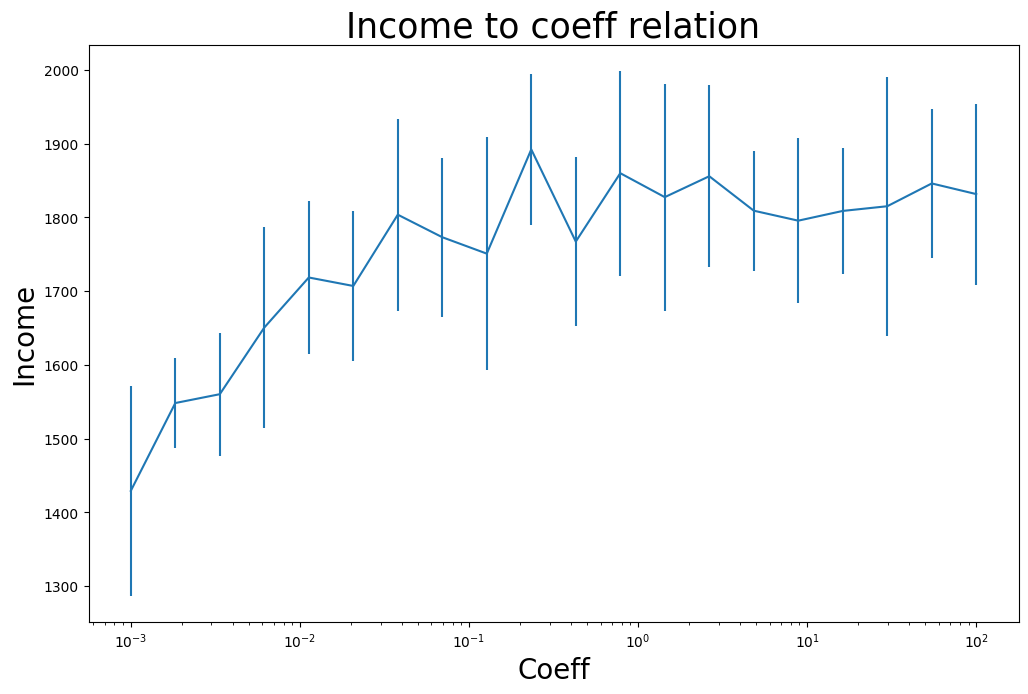

In [83]:
res = []
dev = []

for C in np.logspace(-3, 2, 20):
    preds = np.zeros(y.shape[0])
    model = LogisticRegression(penalty='l2', C=C, random_state=rnd_state, max_iter=300)
    income = []
    salaries = []

    for train_ind, test_ind in cv_folder.split(x_transformed):
        model.fit(x_transformed[train_ind], y[train_ind])
        preds[test_ind] = model.predict(x_transformed[test_ind])

        coeffs = np.random.uniform(0, 20, y[test_ind][preds[test_ind] == 1].shape[0])
        income.append(np.sum(y[test_ind][preds[test_ind] == 1] * coeffs))
        salaries.append(np.sum(preds[test_ind]))

    res.append(np.mean(income) - np.mean(salaries))
    dev.append(np.std(income))

fig = plt.figure(figsize=(12, 7.5))
ax = fig.add_subplot(111)
plt.errorbar(np.logspace(-3, 2, 20), res, dev)
ax.set_title("Income to coeff relation", fontsize=25)
ax.set_xlabel("Coeff", fontsize=20)
ax.set_ylabel("Income", fontsize=20)
plt.xscale('log')
plt.show()

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

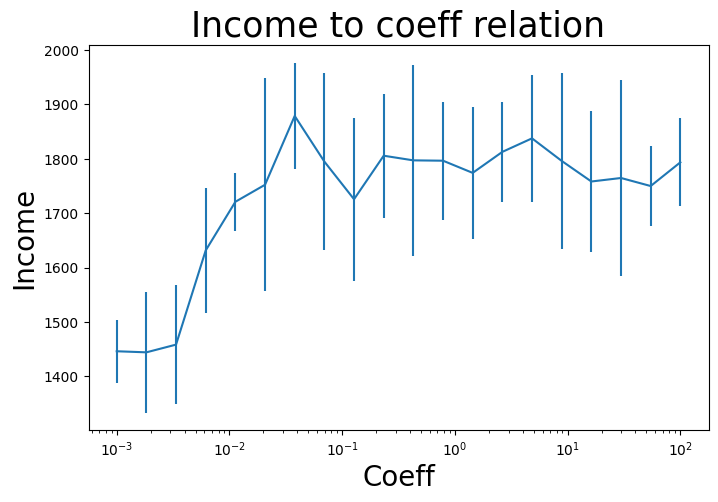

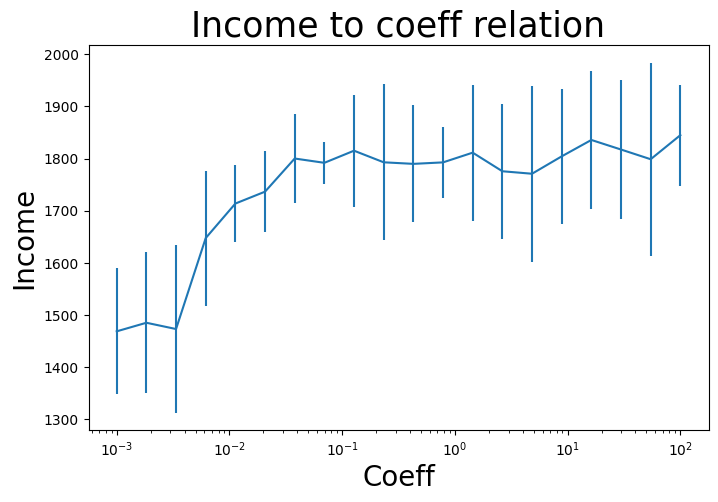

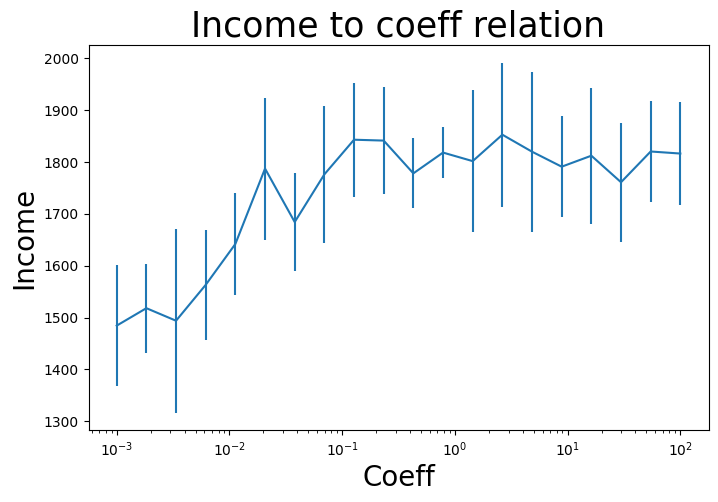

In [84]:
for i in range(3):
    res = []
    dev = []

    for C in np.logspace(-3, 2, 20):
        preds = np.zeros(y.shape[0])
        model = LogisticRegression(penalty='l2', C=C, random_state=rnd_state, max_iter=300)
        income = []
        salaries = []

        for train_ind, test_ind in cv_folder.split(x_transformed):
            model.fit(x_transformed[train_ind], y[train_ind])
            preds[test_ind] = model.predict(x_transformed[test_ind])

            coeffs = np.random.uniform(0, 20, y[test_ind][preds[test_ind] == 1].shape[0])
            income.append(np.sum(y[test_ind][preds[test_ind] == 1] * coeffs))
            salaries.append(np.sum(preds[test_ind]))

        res.append(np.mean(income) - np.mean(salaries))
        dev.append(np.std(income))



    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111)
    plt.errorbar(np.logspace(-3, 2, 20), res, dev)
    ax.set_title("Income to coeff relation", fontsize=25)
    ax.set_xlabel("Coeff", fontsize=20)
    ax.set_ylabel("Income", fontsize=20)
    plt.xscale('log')
    plt.show()

**Ответ: В среднем виден тренд, что при $C\in(10^{-1},10^2)$ мы получаем самые лучшие значения. Точное значение вряд ли получится подобрать, не зафиксировав рандом стейт.**

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

**Ответ: Нам важнее recall, потому что если мы позвоним большему количеству положительных клиентов, то мы получим больше прибыли, хотя и заплатим за каждый звонок.**



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [85]:
from sklearn.metrics import precision_score, recall_score


preds = np.zeros(y.shape[0])
model = LogisticRegression(penalty='l2', random_state=rnd_state, max_iter=300)

calls = [0 for i in range(len(np.arange(0, 1, 0.01)))]
income = [[] for i in range(len(np.arange(0, 1, 0.01)))]
salaries = [[] for i in range(len(np.arange(0, 1, 0.01)))]
iter = 0

for train_ind, test_ind in cv_folder.split(x_transformed):
    iter += 1
    model.fit(x_transformed[train_ind], y[train_ind])
    preds[test_ind] = model.predict_proba(x_transformed[test_ind])[:, 1]

    for step in np.arange(0, 1, 0.01):
        coeffs = np.random.uniform(0, 20, y[test_ind][preds[test_ind] >= step].shape[0])
        income[round(step * 100)].append(np.sum(y[test_ind][preds[test_ind] >= step] * coeffs))
        ct = np.count_nonzero(preds[test_ind] >= step)
        salaries[round(step * 100)].append(ct)
        calls[round(step * 100)] += ct

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог.




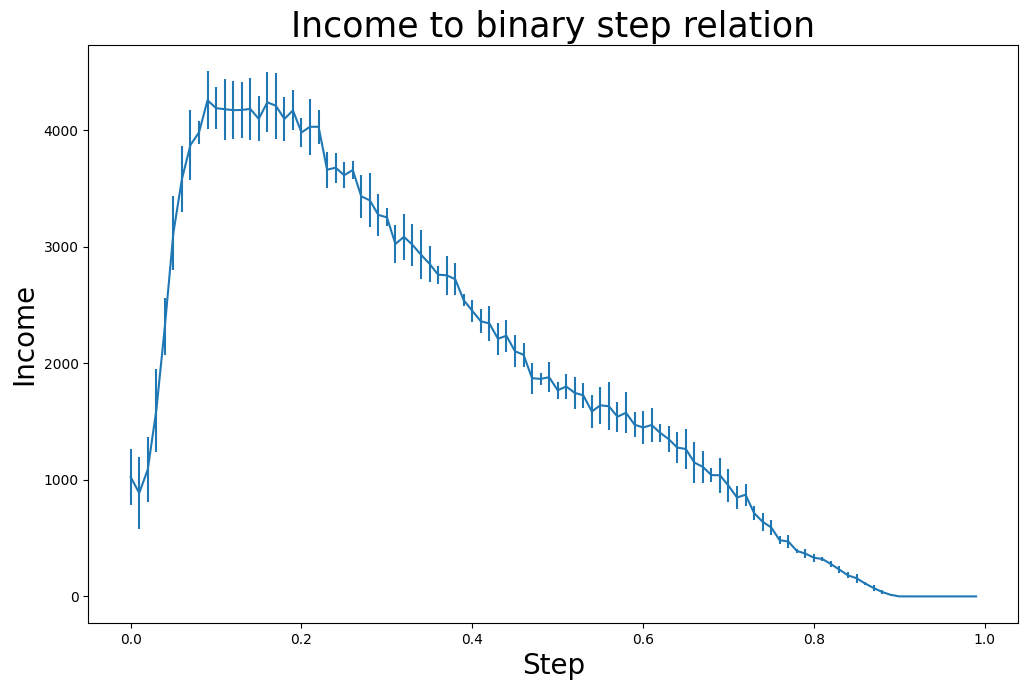

In [86]:
res = []
dev = []
for i in range(len(np.arange(0, 1, 0.01))):
    res.append(np.mean(income[i]) - np.mean(salaries[i]))
    dev.append(np.std(income[i]))

fig = plt.figure(figsize=(12, 7.5))
ax = fig.add_subplot(111)
plt.errorbar(np.arange(0, 1, 0.01), res, dev)
ax.set_title("Income to binary step relation", fontsize=25)
ax.set_xlabel("Step", fontsize=20)
ax.set_ylabel("Income", fontsize=20)
plt.xscale('linear')
plt.show()

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

**Ответ: Да, в основном самый благоприятный порог получается в области $step = 0.15$.**

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [87]:
step = 0.15

preds = np.zeros(y.shape[0])
model = LogisticRegression(penalty='l2', random_state=rnd_state, max_iter=300)
precisions = []
recalls = []
for train_ind, test_ind in cv_folder.split(x_transformed):
    model.fit(pd.DataFrame(x_transformed).loc[train_ind], pd.DataFrame(y).loc[train_ind])
    preds = model.predict_proba(pd.DataFrame(x_transformed).loc[test_ind])[:, 1]

    preds = np.where(preds >= step, True, False)

    new_y_test = pd.DataFrame(y).loc[test_ind]
    precisions.append(precision_score(new_y_test, preds))
    recalls.append(recall_score(new_y_test, preds))

print(f'Mean precision: {np.mean(precisions):.2f}')
print(f'Precision deviation: {np.std(precisions):.2f}')
print(f'Mean recall: {np.mean(recalls):.2f}')
print(f'Recall deviation: {np.std(recalls):.2f}')

Mean precision: 0.39
Precision deviation: 0.01
Mean recall: 0.60
Recall deviation: 0.02


Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

**Будем смотреть на шаги только от 0 до 0.85, так как судя по верхнему графику большие значения нам не дадут ничего полезного.**

In [88]:
preds = np.zeros(y.shape[0])
model = LogisticRegression(penalty='l2', random_state=rnd_state, max_iter=300)

precisions = [[] for i in range(len(np.arange(0, 0.85, 0.01)))]
recalls = [[] for i in range(len(np.arange(0, 0.85, 0.01)))]
for train_ind, test_ind in cv_folder.split(x_transformed):
    model.fit(pd.DataFrame(x_transformed).loc[train_ind], pd.DataFrame(y).loc[train_ind])
    preds = model.predict_proba(pd.DataFrame(x_transformed).loc[test_ind])[:, 1]

    new_y_test = pd.DataFrame(y).loc[test_ind]

    for step in np.arange(0, 0.85, 0.01):
        new_preds = np.where(preds >= step, True, False)

        precisions[round(step * 100)].append(precision_score(new_y_test, new_preds))
        recalls[round(step * 100)].append(recall_score(new_y_test, new_preds))

mean_precs = []
mean_recs = []
for i in range(len(np.arange(0, 0.85, 0.01))):
    mean_precs.append(np.mean(precisions[i]))
    mean_recs.append(np.mean(recalls[i]))
    print(f'On step {i} - mean precision: {mean_precs[i]:.2f}, mean recall: {mean_recs[i]:.2f}')

On step 0 - mean precision: 0.11, mean recall: 1.00
On step 1 - mean precision: 0.11, mean recall: 1.00
On step 2 - mean precision: 0.11, mean recall: 1.00
On step 3 - mean precision: 0.12, mean recall: 0.97
On step 4 - mean precision: 0.14, mean recall: 0.92
On step 5 - mean precision: 0.16, mean recall: 0.86
On step 6 - mean precision: 0.19, mean recall: 0.80
On step 7 - mean precision: 0.23, mean recall: 0.74
On step 8 - mean precision: 0.26, mean recall: 0.70
On step 9 - mean precision: 0.29, mean recall: 0.68
On step 10 - mean precision: 0.32, mean recall: 0.66
On step 11 - mean precision: 0.34, mean recall: 0.64
On step 12 - mean precision: 0.35, mean recall: 0.63
On step 13 - mean precision: 0.37, mean recall: 0.61
On step 14 - mean precision: 0.38, mean recall: 0.61
On step 15 - mean precision: 0.39, mean recall: 0.60
On step 16 - mean precision: 0.40, mean recall: 0.60
On step 17 - mean precision: 0.41, mean recall: 0.59
On step 18 - mean precision: 0.41, mean recall: 0.58
On 

AUC-PR before rearranging: 0.43300



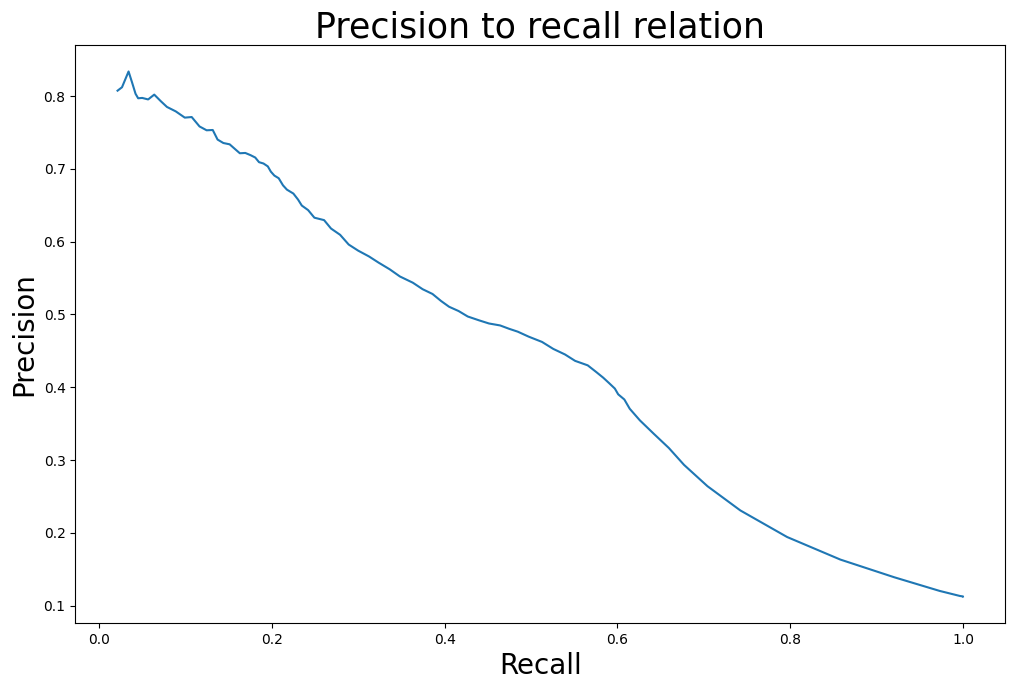

In [89]:
print(f'AUC-PR before rearranging: {auc(mean_recs, mean_precs):.5f}\n')

fig = plt.figure(figsize=(12, 7.5))
ax = fig.add_subplot(111)
plt.plot(mean_recs, mean_precs)
ax.set_title("Precision to recall relation", fontsize=25)
ax.set_xlabel("Recall", fontsize=20)
ax.set_ylabel("Precision", fontsize=20)
plt.show()

AUC-PR after rearranging: 0.39946



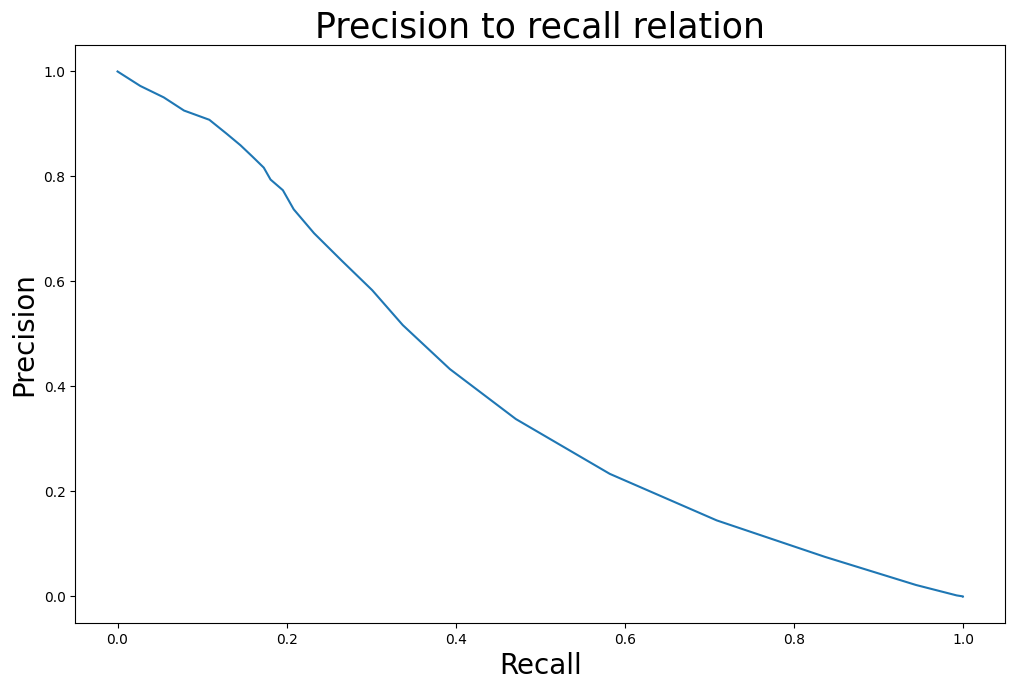

In [90]:
new_recs = np.array([])
new_precs = np.array([])

for (precision, recall) in zip(mean_precs, mean_recs):
    if recall < 0.5:
        break
    new_recs = np.append(new_recs, recall)
    new_precs = np.append(new_precs, precision)

new_recs = (new_recs - np.min(new_recs)) / (np.max(new_recs) - np.min(new_recs))
new_precs = (new_precs - np.min(new_precs)) / (np.max(new_precs) - np.min(new_precs))
print(f'AUC-PR after rearranging: {auc(new_recs, new_precs):.5f}\n')

fig = plt.figure(figsize=(12, 7.5))
ax = fig.add_subplot(111)
plt.plot(new_recs, new_precs)
ax.set_title("Precision to recall relation", fontsize=25)
ax.set_xlabel("Recall", fontsize=20)
ax.set_ylabel("Precision", fontsize=20)
plt.show()

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

**Ответ:**<br>![](https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExdXhqZGRlNHhoNXp2YnBvZ3k0dHUwZjZ5NjNpODIwMnp0d2JzaGh4OCZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/pdJ1kzKWUNmtvbsq2v/giphy.gif)